In [ ]:
!pip install -q transformers datasets evaluate



In [ ]:
!pip install -q neptune

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Huggingface


In [ ]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation


processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")


In [ ]:
from PIL import Image
import requests
import io
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import neptune

# Data

In [ ]:
X_train = np.load('/content/drive/MyDrive/healthcare_practicals/miniproject/data/X_guys_2d.npy')
y_train = np.load('/content/drive/MyDrive/healthcare_practicals/miniproject/data/y_guys_2d.npy')
print(X_train.shape, y_train.shape)

# X_train = centring(X_train)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(valtest_images, valtest_labels, test_size=0.5, random_state=42)


X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[1],X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0],1,X_val.shape[1],X_val.shape[2])
# X_test = X_test.reshape(X_test.shape[0],1,X_test.shape[1],X_test.shape[2])

(317, 128, 128) (317, 352, 352)


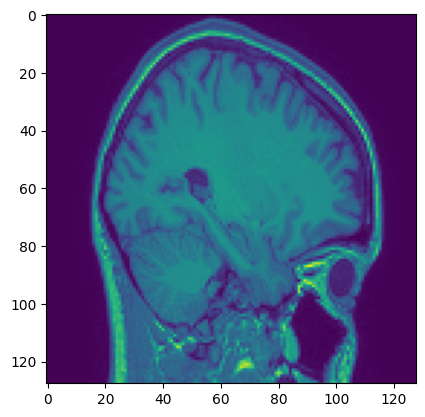

In [ ]:
plt.imshow(X_val[31].squeeze(0))

In [ ]:
from torch.utils.data import Dataset, DataLoader

class numpy_dataset(Dataset):  # Inherit from Dataset class
    def __init__(self, data, target):
        ## Add code here 
        self.data = torch.from_numpy(data)
        self.target = torch.from_numpy(target)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y

    def __len__(self):
        return len(self.data)
    
train_dataset = numpy_dataset(X_train, y_train)
val_dataset = numpy_dataset(X_val, y_val)



In [ ]:
def preprocess_grayscale_image(image, size):
    if len(image.size) == 2:
        image = np.stack((image, image, image), axis=-1)
    return Image.fromarray(image).resize((size, size))

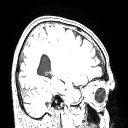

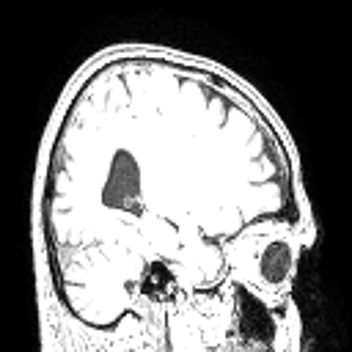

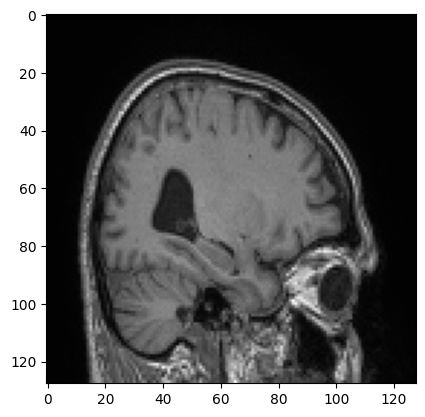

In [ ]:

prompts = ["brain", "cerebral cortex", "cortx", "gray matter", "noodle", "cranium", "encephalon", "medulla oblongata"]
image = Image.fromarray(X_train[0].squeeze(0))
image = image.convert("L")
# (chan,) = image.split()
# print(chan)
# chan.convert("L")
# print(chan)

image.show()
plt.imshow(X_train[0].squeeze(0), cmap='gray')
# print(np.sum(y_train[0]))

seg_img = preprocess_grayscale_image(image, 352)
seg_img

In [ ]:
# inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")

# # predict
# with torch.no_grad():
#   outputs = model(**inputs)

# outputs = torch.sigmoid(outputs.logits)
# outputs.shape

# Simulation of gradient step

In [ ]:
# # Instantiate the model and optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# loss_fn = nn.BCELoss()
# prompts = ["brain"]

# data = torch.rand((16,1,128,128))

# data = data.squeeze(1)
# images = [Image.fromarray(data[i,:,:].numpy()).convert("L") for i in range(data.shape[0])]
# images = [preprocess_grayscale_image(img, 128) for img in images]
# inputs = processor(text=prompts*len(images), images=images, padding="max_length", return_tensors="pt")

# # Forward pass and compute loss
# labels = torch.tensor(y_train[0:16])
# outputs = model(**inputs)
# outputs = torch.sigmoid(outputs.logits).double()
# loss = loss_fn(outputs, labels)

# # Backward pass and compute gradients
# optimizer.zero_grad()
# loss.backward()

# # Manually update the gradients
# with torch.no_grad():
#     optimizer.step()


# seg_img = outputs[0].detach().numpy()
# seg_img = Image.fromarray(seg_img).convert("L")
# seg_img
# # Alternatively, you can use the optimizer to update the parameters:
# # optimizer.step()


In [ ]:
# images[0]

In [ ]:
# seg_img = outputs[0].detach().numpy()
# seg_img = Image.fromarray(seg_img).convert("L")
# seg_img = preprocess_grayscale_image(seg_img, 352)
# seg_img

In [ ]:
# import matplotlib.pyplot as plt

# _, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
# [a.axis('off') for a in ax.flatten()]
# ax[0].imshow(image)
# [ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
# [ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];

# L2 Regularization


In [ ]:
class L2RegLoss(nn.Module):
    def __init__(self, loss_fn=None, mu=1):
        super(L2RegLoss, self).__init__()
        self.eps = 1e-7
        self.mu = mu
        self.loss_fn = loss_fn

    def forward(self, x, target, model):
        main_loss = self.loss_fn(x, target)
        reg_loss = torch.mean(torch.stack([p.norm()**2 for p in model.parameters()]))
        return main_loss + self.mu * reg_loss
    

In [37]:
def train(net, dataloader, optim, loss_fn, epoch):
    start_time = time.perf_counter()
    net.train()  #Put the network in train mode
    total_loss = 0
    total_raw_loss = 0
    batches = 0
    pred_store = []
    true_store = []
    
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = Variable(data), Variable(target)

        # Data Processing to let CLIPSeg accept
        data = data.squeeze(1)
        images = [Image.fromarray(data[i,:,:].numpy()).convert("L") for i in range(data.shape[0])]
        images = [preprocess_grayscale_image(img, 128) for img in images]
        inputs = processor(text=prompts*len(images), images=images, padding="max_length", return_tensors="pt")

        optim.zero_grad()
        # Forward pass and compute loss
        outputs = model(**inputs)
        outputs = torch.sigmoid(outputs.logits).double()
        loss = loss_fn(outputs, target,net)

        # Backward pass and compute gradients
        
        loss.backward()
        # net.zero_grad()

        # Manually update the gradients
        with torch.no_grad():
            optim.step()

        # Update misc
        batches += 1

        
        total_loss += loss
        total_raw_loss += loss_fn.loss_fn(outputs, target)
        


        if batch_idx % 100 == 0: #Report stats every x batches
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, (batch_idx+1) * len(data), len(dataloader.dataset),
                           100. * (batch_idx+1) / len(dataloader), loss.item()), flush=True)
    av_raw_loss = total_raw_loss / batches
    av_loss = total_loss / batches
    av_loss = av_loss.detach().cpu().numpy()
    print('\nTraining set: Average loss: {:.4f}'.format(av_loss,  flush=True))
    total_time = time.perf_counter() - start_time

    model_weight = torch.mean(torch.stack([p.norm() ** 2 for p in net.parameters()]))
    print('Time taken for epoch = ', total_time)
    return av_loss, av_raw_loss, model_weight, (data,outputs,target)

def val(net, val_dataloader, optim, loss_fn, epoch):
    net.eval()  #Put the model in eval mode
    total_loss = 0 
    total_raw_loss = 0   
    pred_store = []
    true_store = []
    batches = 0
    with torch.no_grad():  # So no gradients accumulate
        for batch_idx, (data, target) in enumerate(val_dataloader):
            batches += 1
            data, target = Variable(data), Variable(target)

            # Data Processing to let CLIPSeg accept
            data = data.squeeze(1)
            images = [Image.fromarray(data[i,:,:].numpy()).convert("L") for i in range(data.shape[0])]
            images = [preprocess_grayscale_image(img, 128) for img in images]
            inputs = processor(text=prompts*len(images), images=images, padding="max_length", return_tensors="pt")


            # Forward pass and compute loss
            outputs = model(**inputs)
            outputs = torch.sigmoid(outputs.logits).double()
            loss = loss_fn(outputs, target, net)


            total_loss += loss
            total_raw_loss += loss_fn.loss_fn(outputs, target)
        av_loss = total_loss / batches
        av_raw_loss = total_raw_loss / batches
        
    av_loss = av_loss.detach().numpy()
        
    print('Validation set: Average loss: {:.4f}'.format(av_loss,  flush=True))
    print('\n')
    return av_loss, av_raw_loss, outputs


In [ ]:
class dice_loss(nn.Module):
    def __init__(self):
        super(dice_loss, self).__init__()
        self.eps=1e-7

    def forward(self, x, target):
        num_classes = target.shape[1]   # Channels first
        target = target.type(x.type())
        dims = (0,) + tuple(range(2, target.ndimension()))
        intersection = torch.sum(x * target, dims)
        cardinality = torch.sum(x + target, dims)
        dice_loss = (2. * intersection / (cardinality + self.eps)).mean()
        return 1-dice_loss

In [ ]:
# train_dataset = numpy_dataset(X_train, y_train)
# val_dataset = numpy_dataset(X_val, y_val)

# loss_fn = L2RegLoss(nn.BCELoss(), mu=0.0001)

# train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
# val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True)
# net = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

# with torch.no_grad():  # So no gradients accumulate
#     for batch_idx, (data, target) in enumerate(val_dataloader):
#         data, target = Variable(data), Variable(target)

#         # Data Processing to let CLIPSeg accept
#         data = data.squeeze(1)
#         images = [Image.fromarray(data[i,:,:].numpy()).convert("L") for i in range(data.shape[0])]
#         images = [preprocess_grayscale_image(img, 128) for img in images]
#         inputs = processor(text=prompts*len(images), images=images, padding="max_length", return_tensors="pt")

#         # Forward pass and compute loss
#         outputs = net(**inputs)
#         outputs = torch.sigmoid(outputs.logits).double()
#         loss = loss_fn(outputs, target, net)

# target_img = outputs[0].detach().numpy()*255
# target_img = Image.fromarray(target_img).convert("L")
# loss

In [39]:
prompts = ["brain"]

train_dataset = numpy_dataset(X_train, y_train)
val_dataset = numpy_dataset(X_val, y_val)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True)

net = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

# Calculate the number of traininable params
# print('Trainable params: ', params)


# Neptune
run = neptune.init_run(
    capture_hardware_metrics=True,
    capture_stderr=True,
    capture_stdout=True,
)   

params = {"lr": 1.0, "optimizer": "SGD", "loss": "bce", "epoch": 100, "mu": 0.0, "model": "CLIPSeg_text", "batch_size": 16, "momentum": 0.0}
run["parameters"] = params



loss_dict = {"bce": nn.BCELoss(), "dice": dice_loss()}
optim_dict = {"Adam": torch.optim.Adam(net.parameters(), lr = params["lr"]),
              "SGD" : torch.optim.SGD(net.parameters(), lr = params["lr"], momentum=params["momentum"])
              }

class_loss = loss_dict[params["loss"]]
class_loss = L2RegLoss(class_loss, mu=params["mu"])

optim = optim_dict[params["optimizer"]]

train_dataloader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=params["batch_size"], shuffle=False, drop_last=True)

losses = []
max_epochs = params["epoch"]
for epoch in range(1, max_epochs+1):
    train_loss, train_loss_raw, model_weight, (last_data,last_pred,last_target) = train(net, train_dataloader, optim, class_loss, epoch)
    val_loss, val_loss_raw, last_val_pred = val(net, val_dataloader, optim, class_loss, epoch)

    if epoch % 1 == 0:
        brain_img = Image.fromarray(last_data[0].squeeze(0).cpu().numpy()).convert("L")

        seg_img = last_pred[0].detach().numpy()*255
        seg_img = Image.fromarray(seg_img).convert("L")

        target_img = last_target[0].detach().numpy()*255
        target_img = Image.fromarray(target_img).convert("L")

        seg_val_img = last_val_pred[0].detach().numpy()*255
        seg_val_img = Image.fromarray(seg_val_img).convert("L")
        # Neptune: Image log
        run["train/images"].append(brain_img, description=f"Epoch {epoch}: Input Img \n Avg val loss: {val_loss}")
        run["train/images"].append(seg_img, description=f"Epoch {epoch}: Output Img \n Avg val loss: {val_loss}")
        run["train/images"].append(target_img, description=f"Epoch {epoch}: Target Img \n Avg val loss: {val_loss}") 
        run["train/images"].append(seg_val_img, description=f"Epoch {epoch}: Output Validation Img \n Avg val loss: {val_loss}")
        run["train/temp_segmentation_average"].append(last_pred[0].mean())

    # Neptune: Loss logging
    run["train/train_loss"].append(train_loss)
    run["train/val_loss"].append(val_loss)
    run["train/model_weight"].append(model_weight)
    run["train/train_loss_raw"].append(train_loss_raw)
    run["train/val_loss_raw"].append(val_loss_raw)


torch.save(net.state_dict(), "CLIPSeg_finetune.pth")
run["model_checkpoint/final_model"].upload("CLIPSeg_finetune.pth")


run.stop()

https://app.neptune.ai/miyamura80/DLH-Miniproject/e/DLHMIN-97


TypeError: ignored

In [ ]:
torch.save(net.state_dict(), "CLIPSeg_finetune.pth")
run["model_checkpoint/final_model"].upload("CLIPSeg_finetune.pth")


InactiveRunException: ignored

In [ ]:
run.stop()